In [5]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from tqdm import tqdm
import sys

import pandas as pd
import ast 

import json

import cv2

from torch.nn import Sequential, Sigmoid
from torch import from_numpy, inference_mode
from torch.nn import DataParallel
import torch

from pytorch_lightning import LightningModule

from monai.networks.nets import SwinUNETR
from monai.inferers import sliding_window_inference


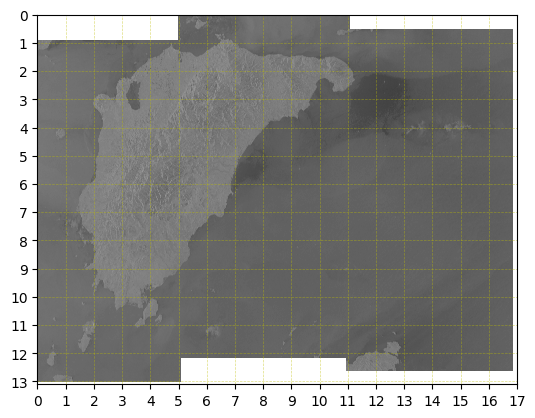

In [6]:
NC_IMAGE_PATH = "/mnt/camobi_process/new_data/images_nc/FAB0.nc"
#NC_IMAGE_PATH = "/mnt/camobi_1/david_files/Datasets/Sem Tratamento/Dados Originais/images_nc/205D.nc"
WEIGHTS_MODEL = "/mnt/camobi_2/PHMG/swin_unetr_models/Model_512Img_24Feature_(2, 2, 2, 2)depths_0.0attnDrop_(3, 6, 12, 24)Heads_30.000000Lr_0drop_v1/model-Val_loss=0.003714-Val_Precision=0.973-Recall=0.971-Val_F1_Score=0.972.ckpt"

nc_img = nc.Dataset(NC_IMAGE_PATH, 'r')


lon = nc_img.variables["longitude"][:]
lat = nc_img.variables["latitude"][:]

lon_lat = np.zeros((len(lon), len(lon[0]), 2))

lon_lat[:,:,0] = lon
lon_lat[:,:,1] = lat

nc_img = nc_img.variables["Sigma0_VV_db"][:]
nc_img = nc_img.filled(np.nan)

plt.imshow(nc_img, cmap="gray")
y_ticks = np.arange(0, len(nc_img), 1000)
x_ticks = np.arange(0, len(nc_img[0]), 1000)

plt.yticks(y_ticks, labels=np.arange(len(y_ticks)))
plt.xticks(x_ticks, labels=np.arange(len(x_ticks)))
plt.grid(color='y', linestyle='--', linewidth=0.5, alpha=0.5)


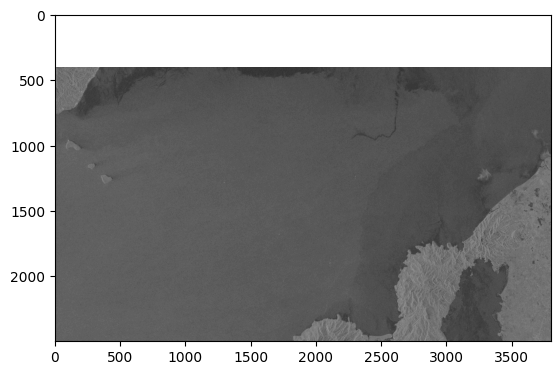

In [8]:
crop_region = {
    "x_start": 500,
    "x_end": 3000,
    "y_start": 200,
    "y_end": 4000
}

croped_img = nc_img[crop_region["x_start"]:crop_region["x_end"], crop_region["y_start"]:crop_region["y_end"]]
plt.imshow(croped_img, cmap="gray")

In [139]:
point_input = np.array([-89.054, 28.736])
point_input_2 = np.array([-88.922, 28.968])

location = closest_node(point_input, lon_lat)
location_2 = closest_node(point_input_2, lon_lat)
print(location, location_2)
lon_lat[location]

def closest_node(point, matrix):
    deltas = abs(matrix - point)
    sum_array = np.sum(deltas, axis=2)
    return np.where(sum_array == np.min(sum_array))

crop_region = {
    "x_start": 0,
    "x_end": -1,
    "y_start": 0,
    "y_end": -1
}

croped_img = nc_img[crop_region["x_start"]:crop_region["x_end"], crop_region["y_start"]:crop_region["y_end"]]
plt.imshow(croped_img, cmap="gray")
test = lon_matrix[crop_region["x_start"]:crop_region["x_end"], crop_region["y_start"]:crop_region["y_end"]]

NameError: name 'closest_node' is not defined

In [167]:
class PedroNet(LightningModule): #out_channels = numero de classes
    def __init__(self, img_size, lr,
                 depths=(2, 2, 2, 2), 
                 num_heads=(3, 6, 12, 24), 
                 feature_size=24, 
                 norm_name='instance', 
                 drop_rate=0.0, 
                 attn_drop_rate=0.0, 
                 dropout_path_rate=0.0, 
                 normalize=True, 
                 use_checkpoint=False, 
                 downsample='merging', 
                 use_v2=False 
                 ):
        super().__init__()
        self.model = Sequential(SwinUNETR(spatial_dims=2,
                                    in_channels=1,
                                    out_channels=1,
                                    depths=depths,
                                    img_size=img_size,
                                    feature_size=feature_size,
                                    drop_rate=drop_rate,
                                    num_heads=num_heads,
                                    norm_name=norm_name,
                                    attn_drop_rate=attn_drop_rate,
                                    dropout_path_rate=dropout_path_rate,
                                    normalize=normalize,
                                    use_checkpoint=use_checkpoint,
                                    downsample=downsample,
                                    #use_v2=use_v2, apenas para versões mais recentes
                                    ))
    def forward(self, x):
        return self.model(x)
    
loaded_model = PedroNet.load_from_checkpoint(WEIGHTS_MODEL)
loaded_model = DataParallel(loaded_model)
loaded_model = loaded_model.to("cuda")

tensor_img = from_numpy(croped_img)
tensor_img = tensor_img.unsqueeze(0).unsqueeze(0)


with inference_mode():
    model_img = sliding_window_inference(tensor_img, 
                                    roi_size=(512),
                                    sw_batch_size=64, 
                                    predictor=loaded_model, 
                                    mode='constant',
                                    overlap=0.9,
                                    progress=True,
                                    sw_device="cuda"
                                    )

sigmoid_fn = Sigmoid()
prob_result = sigmoid_fn(model_img)
prob_result = prob_result.squeeze()
prob_result = prob_result.to("cpu")

100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


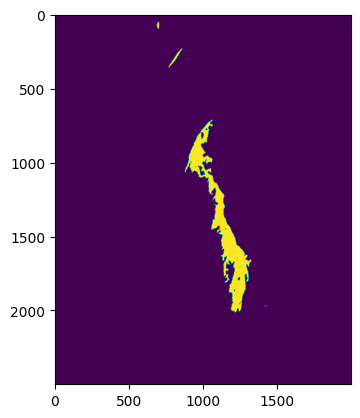

In [169]:
#fig, axs = plt.subplots(ncols=2)

threshold = 0.5
mask_result = np.asarray(prob_result)
mask_result[mask_result > threshold] = 1
mask_result[mask_result < threshold] = 0


#axs[0].imshow(mask_result)
#axs[1].imshow(croped_img)
plt.imshow(mask_result)


#fig.set_size_inches(14, 7)


481 2379
20 164


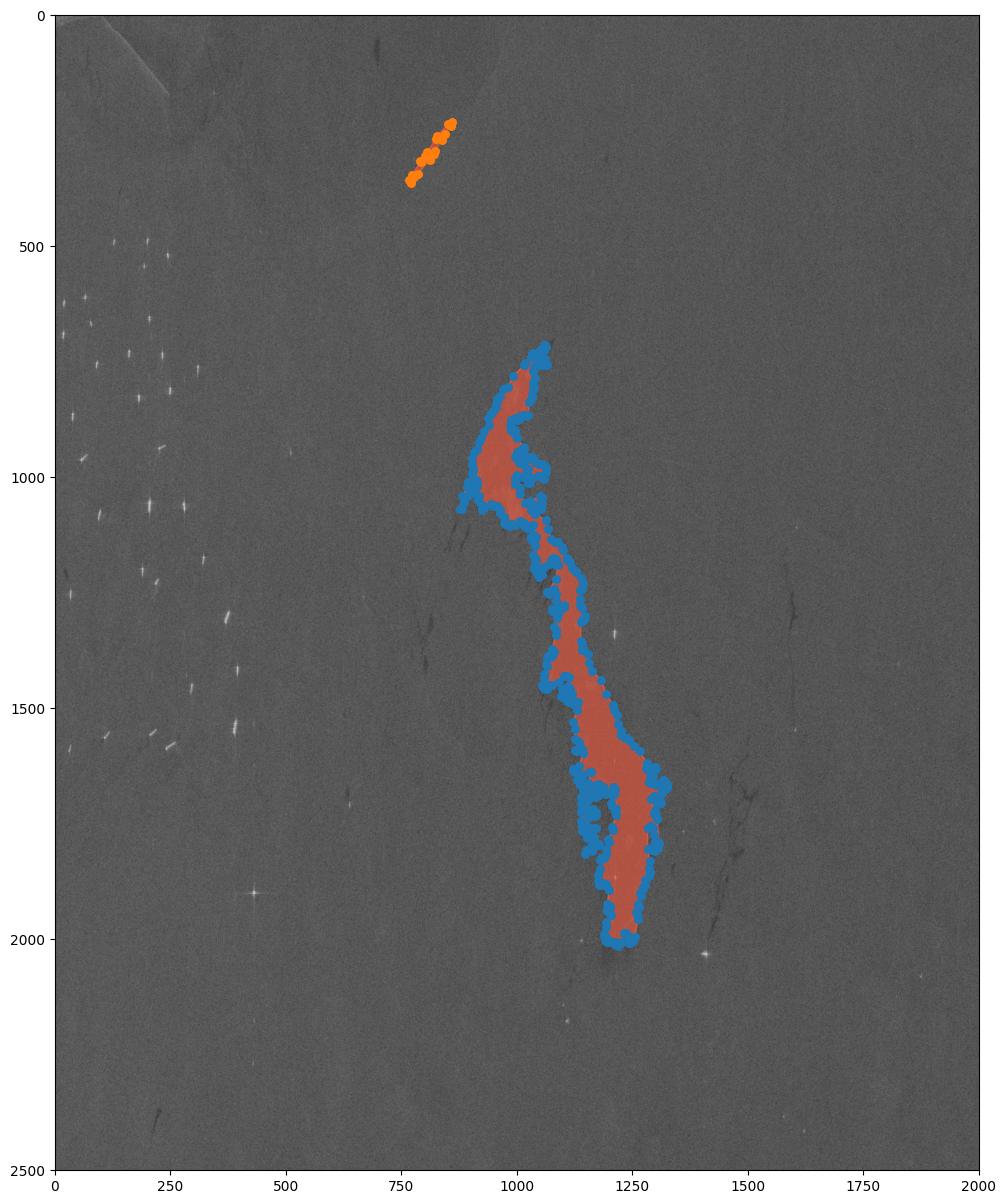

In [174]:
import cv2
import numpy as np
#import imutils
#from shapely.geometry import Polygon
import matplotlib.pyplot as plt
edited_contours = []

# Generate a sample binary image
binary_image = np.array(mask_result)
#cv2.RETR_TREE
# Find contours in the binary image
contours, hierarchy = cv2.findContours(binary_image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(hierarchy)

fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
ax.imshow(croped_img, cmap="gray")
ax.set_xlim(0, len(mask_result[0]))
ax.set_ylim(len(mask_result), 0)

#cnts = imutils.grab_contours(cnts)
for poly in contours:
    if len(poly) > 50:
        approx = cv2.approxPolyDP(poly, 1.5, True)
        approx = np.squeeze(approx)
        polygon = Polygon(approx, facecolor="tomato", edgecolor="tomato", alpha=0.6)
        ax.add_patch(polygon)
        ax.scatter(approx[:, 0], approx[:, 1], s=30)
        print(len(approx), len(poly))
        edited_contours.append(approx)  

#ax.set_xlim(200, 400)
#ax.set_ylim(0, 600)

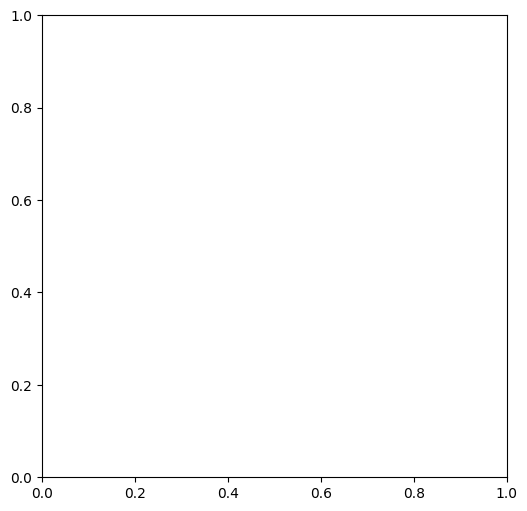

In [175]:
fig, ax = plt.subplots()
#ax.imshow(nc_img, cmap="gray")
fig.set_size_inches(6, 6)
#ax.set_xlim(0, len(mask_result[0]))
#ax.set_ylim(len(mask_result), 0)

new_patches = []
for poly in edited_contours:
    poly = np.asarray(poly)
    poly = poly.squeeze()
    poly = poly + [crop_region["y_start"], crop_region["x_start"],]
    #display(poly)
    polygon = Polygon(poly, color="tomato")
    ax.add_patch(polygon)
    #print(len(poly))
    new_patches.append(poly)
        
        
image_name = NC_IMAGE_PATH[-7:-3]
#plt.savefig(f"{image_name}.jpeg", edgecolor='black', dpi=500, transparent=True)

In [176]:


labelme_format = {
    "version": "5.1.1",
    "flags": {},
    "shapes": [],
    "imagePath": f"..\\Sar_img\\{image_name}.png",  # Update with your image filename
    "imageData": None,
    "imageHeight": nc_img.shape[0],
    "imageWidth": nc_img.shape[1]
}



# Add shapes to the dictionary
for patch in new_patches:
    labelme_format["shapes"].append({
        "label": "oil", 
        "points": patch.squeeze().tolist(),
        "group_id": None,
        "description": "",
        "shape_type": "polygon",
        "flags": {}
    })

auto_labels = "/mnt/camobi_2/PHMG/Sentinel_Acquisition/auto_labels/{image_name}.json"
with open(auto_labels.format(image_name=image_name), 'w') as json_file:
    json.dump(labelme_format, json_file, indent=2)

#labelme_format

In [2]:
import os
import json
folder = "/mnt/camobi_1/david_files/Datasets/Sem Tratamento/Dados Originais/labels_json"
another_folder = "/mnt/camobi_process/new_data/test"
for item in os.listdir(folder):
    item_path = os.path.join(folder, item)
    json_file = json.load(open(item_path, "r"))
    json_file["imageData"] = None
    with open(os.path.join(another_folder, item), 'w') as f:
        json.dump(json_file, f, indent=2)